In [1]:
%matplotlib inline
from __future__ import division, print_function
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import sys, os, time
import fitsio
import healpy as hp
from sklearn import cluster

--------
## Optimization

__Load previous results:__

In [2]:
NSIDE = 2**7
npix = hp.nside2npix(NSIDE)
t = Table.read('/Users/roz18/git/desi-photoz/test/clustering_demo_results.txt', format='ascii.commented_header')

hp_ra = np.array(t['ra'])
hp_dec = np.array(t['dec'])
density = np.array(t['density'])
counts = np.array(t['count'])
labels_original = np.array(t['label'])

labels = np.copy(labels_original)

__Identify the neighbors of each occupied pixel:__

3010 bordering pixels


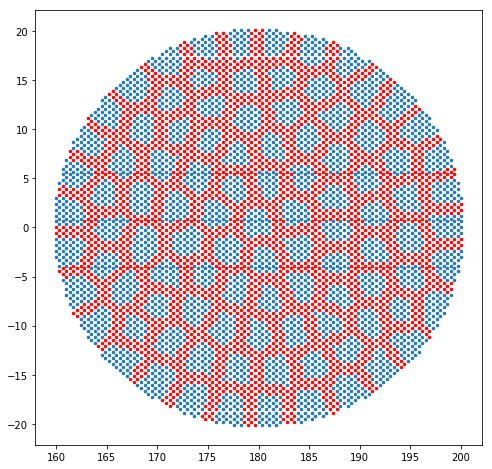

In [3]:
pix_id = hp.pixelfunc.ang2pix(NSIDE, hp_ra, hp_dec, lonlat=True)

neighbors = hp.get_all_neighbours(NSIDE, hp_ra, hp_dec, lonlat=True).T
mask = np.in1d(neighbors, pix_id).reshape(neighbors.shape)
neighbors[~mask] = -1

# Convert to native numpy indices of the pixels
# pointer from healpy indices to pixel indices:
pointer = -99 * np.ones(npix, dtype=int)
for index in range(len(hp_ra)):
    pointer[pix_id[index]] = index
neighbors[mask] = pointer[neighbors[mask]]

# Find bordering pixels
mask1 = labels[neighbors] != labels[:, None]
mask2 = neighbors>=0
mask_border = np.any(mask1 & mask2, axis=1)
print(np.sum(mask_border), 'bordering pixels')
plt.figure(figsize=(8, 8))
plt.plot(hp_ra[~mask_border], hp_dec[~mask_border], '.', markersize=5)
plt.plot(hp_ra[mask_border], hp_dec[mask_border], 'r.', markersize=5)
plt.show()

In [4]:
# Default parameters:
default_params = {
    'mutate_rate': 0.001,
    'ngen': 100000,  # number of generations to run
    'equality_weight': 80., # weight of imposing equal weighted pix counts in fitness function
    'spherical': True, 
}

ngroup = len(np.unique(labels))

In [6]:
import optimized_pixel_partition_greedy
# reload(optimized_pixel_partition_greedy)

# Initialize
optimizer = optimized_pixel_partition_greedy.Subsampler(hp_ra, hp_dec, ngroup, neighbors, weights=counts, **default_params)

-----------
__Evolve!__

In [7]:
# np.random.seed(2)

# fitness scores of the initial configuration
score, compactness, equality, w_counts = optimizer.fitness(labels)

############################## Evolve! ##############################
time_start = time.time()
for idx_gen in range(default_params['ngen']):
    
    # mutate
    labels_new = optimizer.mutate(labels)
    score_temp, compactness_temp, equality_temp, w_counts_temp = optimizer.fitness(labels_new)
    
    if score_temp > score:
        labels = labels_new
        score, compactness, equality, w_counts = \
        score_temp, compactness_temp, equality_temp, w_counts_temp
    
    if idx_gen%1000==0:
        print('{:5d} {:11.8g} {:11.8g} {:11.8g}'.\
              format(idx_gen, score, compactness, equality))

print(time.strftime("%H:%M:%S", time.gmtime(time.time() - time_start)))

    0  -160.86067    145.2583   15.602371
 1000  -160.35279   145.77045   14.582339
 2000  -159.56482   146.21332   13.351498
 3000  -158.87895   146.54698   12.331978
 4000   -158.0938   146.61094   11.482856
 5000  -157.35291   146.69044   10.662473
 6000  -156.66841   146.84687   9.8215462
 7000   -155.9132   146.84927   9.0639298
 8000   -155.1469   146.92839   8.2185157
 9000  -154.27908   146.94198   7.3370969
10000  -153.53059   146.81584   6.7147526
11000  -152.80911   146.75285   6.0562587
12000  -152.33506   146.84208   5.4929754
13000  -151.54116    146.6944    4.846756
14000  -150.90184   146.74596    4.155877
15000   -150.4695   146.77979   3.6897085
16000  -150.01226   146.67443   3.3378254
17000  -149.70336   146.65837     3.04499
18000  -149.35579   146.59604    2.759755
19000  -149.08882   146.56252   2.5262999
20000  -148.89383   146.59562   2.2982146
21000  -148.72653   146.60088   2.1256495
22000  -148.53808   146.49798    2.040098
23000  -148.37636   146.42907    1

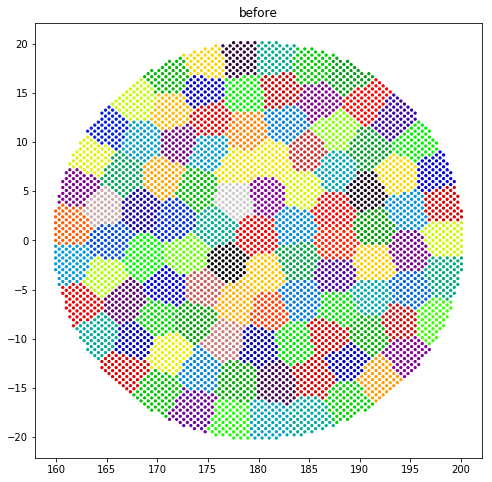

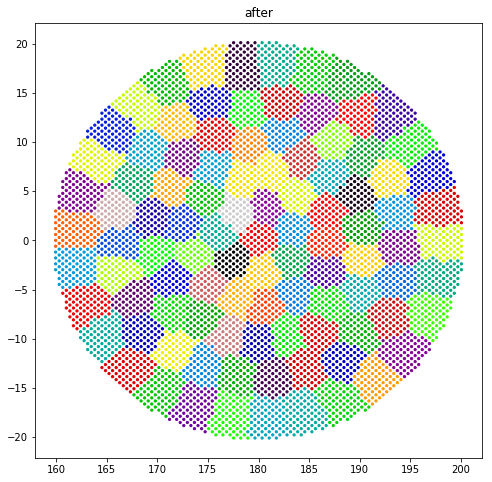

In [8]:
# Original grouping
plt.figure(figsize=(8, 8))
plt.scatter(hp_ra, hp_dec, c=labels_original, cmap=plt.cm.spectral, s=5)
plt.title('before')
plt.show()

# Final grouping
plt.figure(figsize=(8, 8))
plt.scatter(hp_ra, hp_dec, c=labels, cmap=plt.cm.spectral, s=5)
plt.title('after')
plt.show()

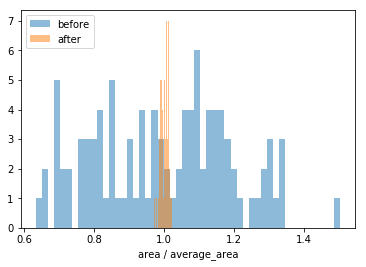

In [9]:
group_counts_original = np.zeros(ngroup)
for idx_grp in range(ngroup):
    members = np.where(labels_original==idx_grp)[0]
    group_counts_original[idx_grp] = np.sum(counts[members])

plt.hist(group_counts_original/optimizer.average_count, 50, alpha=0.5, label='before')
plt.hist(w_counts/optimizer.average_count, 50, alpha=0.5, label='after')
plt.legend(loc='upper left')
plt.xlabel('area / average_area')
plt.show()

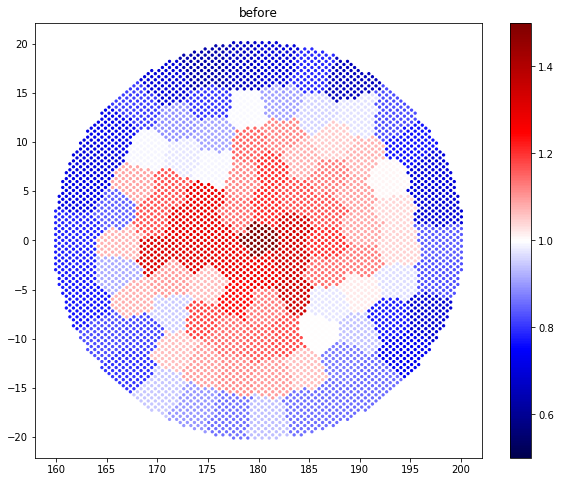

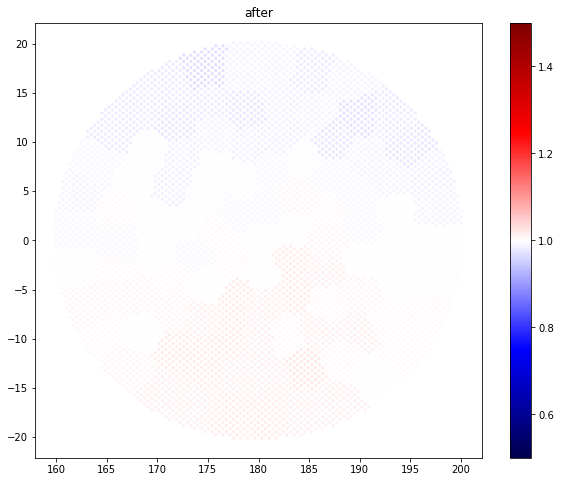

In [10]:
counts_pix_original = group_counts_original[labels]
plt.figure(figsize=(10, 8))
plt.scatter(hp_ra, hp_dec, c=counts_pix_original/optimizer.average_count,
            cmap=plt.cm.seismic, s=5, vmin=0.5, vmax=1.5)
plt.colorbar()
plt.title('before')
plt.show()

counts_pix = w_counts[labels]
plt.figure(figsize=(10, 8))
plt.scatter(hp_ra, hp_dec, c=counts_pix/optimizer.average_count,
            cmap=plt.cm.seismic, s=5, vmin=0.5, vmax=1.5)
plt.colorbar()
plt.title('after')
plt.show()